# Basic Rasterization

**Framebuffers, Dispatching Primitives, Instances**

A distinctive aspect of a rasterizer is the way output is handled. In a compute shader, the generated image is accessed at random positions to store output values. In a rasterizer, it's convenient that multiple render targets and depth-stencil buffers are aligned, and there's an implicit process that consumes colors, depth, and stencil values, operates on them, and updates the respective buffers.

The color attachments can be written to in the fragment shader using `out` locations. Depth and stencil operations can be statically defined in the graphics pipeline or configured dynamically via the command buffer manager.

In this tutorial, we will render different quads to demonstrate the setup of graphics pipelines and how instancing works.


In [1]:
try: # install all dependencies in colab 
    import google.colab
    !sudo apt-get update -y
    !sudo apt-get install -y libnvidia-gl-555 vulkan-tools glslang-tools vulkan-validationlayers-dev
    !pip install pyav==13.1.0
    !pip install git+https://github.com/rendervous/vulky_project.git
except:
    print("Executing locally")

Executing locally


In [2]:
import vulky as vk
import torch

vk.create_device(debug=True)

[INFO] Debug instance created...
[PRINT] Inserted device layer "VK_LAYER_KHRONOS_validation" (C:\VulkanSDK\1.3.275.0\Bin\.\VkLayer_khronos_validation.dll)
[PRINT] Inserted device layer "VK_LAYER_OBS_HOOK" (C:\ProgramData\obs-studio-hook\.\graphics-hook64.dll)
[PRINT] Inserted device layer "VK_LAYER_NV_optimus" (C:\WINDOWS\System32\DriverStore\FileRepository\nv_dispi.inf_amd64_cc569e59ca39c5fe\.\nvoglv64.dll)
[PRINT] vkCreateDevice layer callstack setup to:
[PRINT]    <Application>
[PRINT]      ||
[PRINT]    <Loader>
[PRINT]      ||
[PRINT]    VK_LAYER_NV_optimus
[PRINT]            Type: Implicit
[PRINT]                Disable Env Var:  DISABLE_LAYER_NV_OPTIMUS_1
[PRINT]            Manifest: C:\WINDOWS\System32\DriverStore\FileRepository\nv_dispi.inf_amd64_cc569e59ca39c5fe\nv-vk64.json
[PRINT]            Library:  C:\WINDOWS\System32\DriverStore\FileRepository\nv_dispi.inf_amd64_cc569e59ca39c5fe\.\nvoglv64.dll
[PRINT]      ||
[PRINT]    VK_LAYER_OBS_HOOK
[PRINT]            Type: Implici

Next, we’ll define a set of constants to help parameterize and control the behavior of our example.

In [3]:
SCREEN_WIDTH = 512
SCREEN_HEIGHT = 512
NUMBER_OF_SPRITES = 30

We'll create two images: one for the render target and another for the depth buffer. Both images will share the same dimensions. Vulkan automatically uses a higher-definition format for the depth-stencil buffer, ensuring more precise depth and stencil operations.

These buffers will be used during the rendering process to store color information (render target) and depth/stencil information (depth buffer).

In [4]:
render_target = vk.render_target(
    image_format=vk.Format.VEC4,
    width=SCREEN_WIDTH,
    height=SCREEN_HEIGHT
)

depth_buffer = vk.depth_stencil(
    width=SCREEN_WIDTH,
    height=SCREEN_HEIGHT
)

We will create a buffer that stores the properties of the sprites, allocating one for each individual instance.


In [5]:
sprite_properties = vk.structured_buffer(
    count=NUMBER_OF_SPRITES,
    element_description=dict(
        offset=vk.vec3,
        size=float,
        color=vk.vec4,
    )
)

Next, we'll populate the buffer with random values. Each entry will represent a box on the screen, with the `z` offset indicating depth and the color of the box.


In [6]:
with sprite_properties.map(mode='in', clear=True) as b:
    b.offset = torch.rand(NUMBER_OF_SPRITES, 3)*2 - 1.0
    b.offset.z *= 0.5
    b.offset.z += 0.5
    b.size = torch.randn(NUMBER_OF_SPRITES, 1)*0.05
    b.color = vk.vec4(0.5, 0.5, 0.5, 0.5) + torch.randn(NUMBER_OF_SPRITES, 4)*0.1
    # b.color is a vec4, b.color[0] is not the first color but the first component for all colors
    b.color[0] = 1.0  # set the red component for all 30 colors to 1.
    # but cast to torch.Tensor is possible, meaning that is valid
    b.color.as_subclass(torch.Tensor)[:NUMBER_OF_SPRITES//2, 3] = 1.0  
    # That makes all alpha components for the first 15 colors 1.0

Mapped buffers allow access through individual fields. Assigning a value to a field copies a tensor or constant across all elements in the buffer. Note that if the field contains a vector or matrix, indexing behavior will differ accordingly. Now, let's move on to defining the vertex and fragment shader code.


In [7]:
vertex_shader_code = """
#version 450
#extension GL_EXT_scalar_block_layout: enable

layout(location = 0) out vec4 out_color;

struct SpriteInfo
{
    vec3 offset;
    float size;
    vec4 color;
};

layout(scalar, set=0, binding=0) buffer SpriteInfos {
    SpriteInfo[] data;
} infos;

vec2[] quad = {
    vec2(-1.0, -1.0), 
    vec2(1.0, -1.0),
    vec2(-1.0, 1.0),
    vec2(-1.0, 1.0),
    vec2(1.0, -1.0),
    vec2(1.0, 1.0)
};

void main()
{
    SpriteInfo info = infos.data[gl_InstanceIndex];
    vec4 P = vec4(vec3(quad[gl_VertexIndex], 0)*info.size + info.offset, 1.0);
    gl_Position = P;
    out_color = info.color;
}
"""
fragment_shader_code = """
#version 450
layout(location = 0) in vec4 in_color;
layout(location = 0) out vec4 out_color;
void main()
{
    out_color = in_color;
}
"""

Keep in mind that the vertex shader will utilize the built-in variables `gl_VertexIndex` and `gl_InstanceIndex`. Next, we'll define the pipeline object, which connects the shaders, resource bindings, and framebuffer targets.


In [8]:
pipeline = vk.pipeline_graphics()
pipeline.attach(0, render_target=vk.Format.VEC4)
pipeline.attach(1, depth_buffer=vk.Format.DEPTH_STENCIL)
pipeline.layout(set=0, binding=0, sprite_properties=vk.DescriptorType.STORAGE_BUFFER)
with pipeline.shader_stages(vk.ShaderStage.VERTEX):
    pipeline.load_shader_from_source(vertex_shader_code)
with pipeline.shader_stages(vk.ShaderStage.FRAGMENT):
    pipeline.load_shader_from_source(fragment_shader_code)
pipeline.close()

Once the pipeline is finalized, its layout becomes fixed, allowing the creation of dependent objects such as framebuffers and descriptor set collections. The framebuffer object specifies the images that will be attached to the pipeline during execution. In Vulkan, a render pass— which includes a framebuffer— can consist of multiple subpasses to optimize dependencies between render targets. In Vulky, this concept is simplified to a single subpass.
  

In [9]:
framebuffer = pipeline.create_framebuffer(
    width=SCREEN_WIDTH,
    height=SCREEN_HEIGHT,
    render_target=render_target,
    depth_buffer=depth_buffer
)

The pipeline is also responsible for creating the descriptor set, which in this example is used to bind a buffer containing all sprite properties.


In [10]:
global_bindings = pipeline.create_descriptor_set_collection(set=0, count=1)
global_bindings[0].update(sprite_properties=sprite_properties)

Next, we'll populate a command buffer. In this example, we record commands using a manager and then freeze the buffer before submitting it. This approach allows Vulky to re-submit the same command buffer multiple times. However, in this case, we’ll submit it only once—similar to using it within a single rendering context.


In [11]:
man = vk.graphics_manager()

Now, we can clear the render target using a dark blue color. Image transitions aren't required explicitly, as they are handled internally when needed. That said, image barriers are still supported, but they are only used to synchronize operations between different sections of the command buffer.


In [12]:
man.clear_color(render_target, (0.0, 0.0, 0.4, 1.0))
man.clear_depth_stencil(depth_buffer, 1.0, 0)

Next, we’ll set the pipeline, bind the framebuffer and the global descriptor set.


In [13]:
man.set_pipeline(pipeline)
man.set_framebuffer(framebuffer)
man.set_viewport(0.0, framebuffer.height, framebuffer.width, -framebuffer.height)
man.bind(global_bindings[0])

At this stage, the graphics pipeline is fully configured, and an implicit render pass is active for drawing primitives. By default, the pipeline assumes a triangle topology, though this can be changed. The next instruction will dispatch 30 instances, each consisting of 6 vertices (forming 2 triangles per instance).


In [14]:
man.dispatch_primitives(vertices=6, instances=30)

Once the command buffer is populated, we use `freeze` to finalize it and prepare it for submission.

In [15]:
man.freeze()

Now, we instruct Vulky to submit a command buffer. The difference between `close` and `freeze` is that when a command buffer is closed, its internal buffer is released and can be reused for recording new commands. In contrast, `freeze` preserves the buffer, allowing it to be re-submitted if necessary.


In [16]:
vk.submit(man)

Next, we copy the render target to a staging buffer. 

In [17]:
staging = vk.tensor(render_target.height, render_target.width, 4) 
render_target.save(staging)

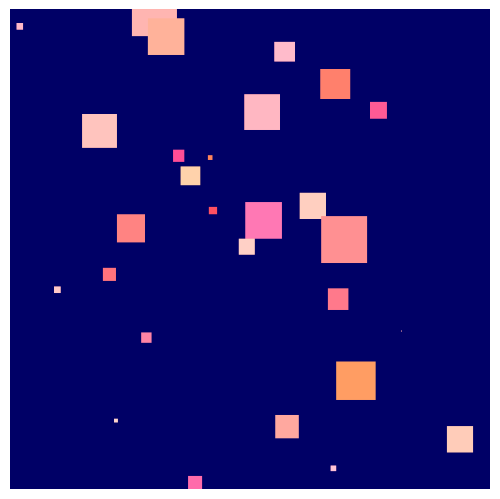

In [18]:
import matplotlib.pyplot as plt
plt.imshow(staging.cpu())
plt.gca().axis('off')
plt.tight_layout(pad=0.0)
plt.show()

Let's prepare a simple animation for this example

In [19]:
video_data = vk.tensor(100, SCREEN_HEIGHT, SCREEN_WIDTH, 3)  # 100 frames
initial_offset = torch.rand(NUMBER_OF_SPRITES, 3)*2 - 1.0
initial_offset[..., 2] *= 0.5
initial_offset[..., 2] += 0.5

In [20]:
for i in range(len(video_data)):
    alpha = i / len(video_data)
    # update buffer
    # we use inout because we won't change everything, just a field
    with sprite_properties.map(mode='inout') as b:  
        b.offset = initial_offset
        b.offset.y += torch.abs(torch.sin(((initial_offset[...,0] * 100)%1.0)*10 + alpha*30))*0.1
        b.offset.x += torch.cos(((initial_offset[...,1]*40)%1.0)*10 + alpha*4)*0.3
    # re-submit commands to gpu
    with vk.graphics_manager() as b:  # transit from general to render target before rendering
        b.use(render_target, vk.ImageUsage.ANY)
        b.image_barrier(render_target, vk.ImageUsage.RENDER_TARGET)
    vk.submit(man)  # by default will wait until finishes
    with vk.graphics_manager() as b:  # transit from render target to general before saving
        b.use(render_target, vk.ImageUsage.RENDER_TARGET)
        b.image_barrier(render_target, vk.ImageUsage.ANY)
    render_target.save(staging)
    video_data[i] = staging[...,:3]  # copy current frame to video (only RGB)
vk.save_video(video_data, 'teaser3.webp', 10, quality=100)

In [21]:
vk.notebook_show('teaser3.webp')